In [1]:
#pip install openeo[localprocessing]

In [5]:
from openeo.local import LocalConnection
import xarray as xr
from openeo.processes import and_, is_valid, filter_temporal
import pandas as pd
import numpy as np


## Gapfilling
<div>
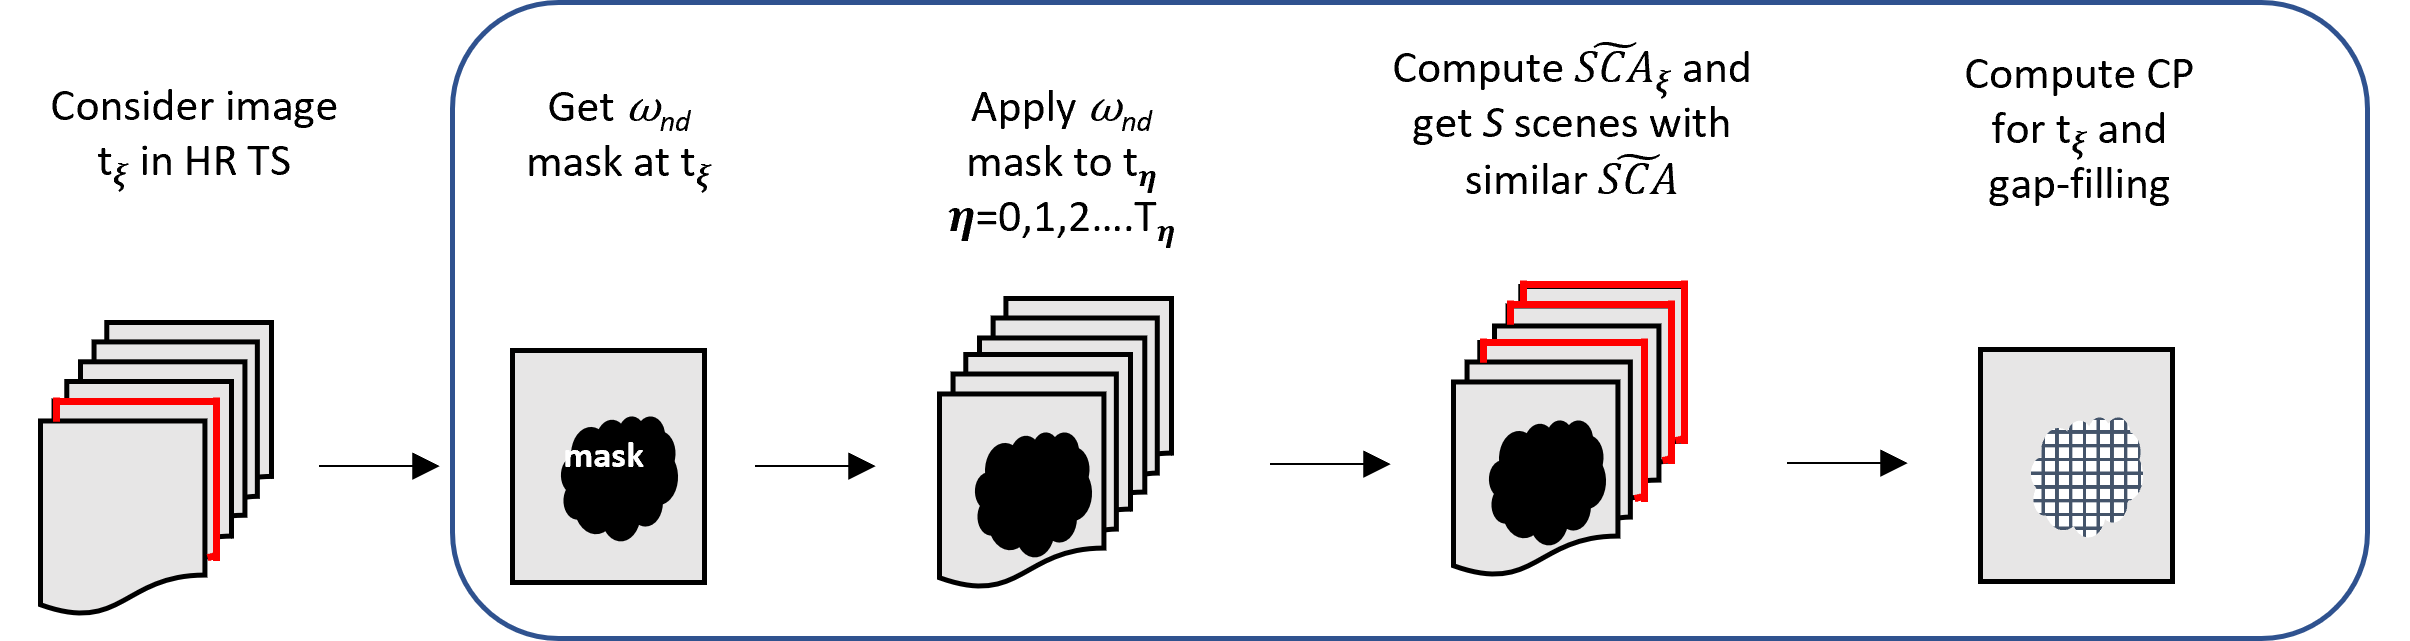
</div>


- Applied to any HR maps with gaps;
- Based on the partial observed/reconstructed SCA, i.e., the SCA computed by excluding the no data values;
- Conditional probability to observe a pixel as snow given the historical HR snow pattern persistence:

 
$$
P_{i}(\omega_{s}|\widetilde{SCA}) = \frac{\sum_{s=0}^{S}x_{i}^{s}}{S}, \: i \subset \text{mask}
$$

Hence it follows:

$$
\begin{split}
    x_{i}=\omega_{s}, \:  & \textbf{if} \:  P_{i}(\omega_{s}|\widetilde{SCA}) = 1 \\
     x_{i}=\omega_{sf}, \:  & \textbf{if} \:  P_{i}(\omega_{s}|\widetilde{SCA}) = 0 
\end{split}
$$


In [6]:
local_conn = LocalConnection("./")
s2_path = "/home/vpremier/OEMC/SCA/daily_sca_reconstruction/results/scf_binary.nc"

cube_ = local_conn.load_collection(s2_path)

### Replace non valid values

In [7]:
# different from nan (that is snow free)
mask_non_nv = is_valid(cube_) 
# nan (that is equal to snow free) -> this workaround has to be done since fillna is not implemented
mask_sf = mask_non_nv.apply(process='not') 
cube = cube_.mask(mask_sf,replacement=0)

Define constant values to be used in the notebook.

In [8]:
# Ratio betweeen the size of a LR and a HR pixel, e.g., 500 m and 20 m.
pixel_ratio = 25 
# non-valid values
codes = [205, 210, 254, 255] 
nv_value = 205
# Threshold of non valid HR pixels allowed within a LR pixel [%]
nv_thres = 10 

# delta and epsilon: are used to define the SCF ranges. 
# The delta defines the steps, while epsilon represents a security buffer
delta = 10
epsilon = 10

#
sim_thres = 95
sca_thres = 5

### Create the cloud/non valid mask 

Same as in downscaling until mask_valid

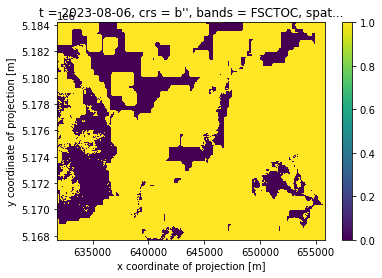

In [9]:
# cloud/non valid pixels
mask_clouds = cube > 100  

clouds = mask_clouds.execute()
clouds[0,0].plot.imshow()

For each date of the Sentinel-2 time-series, select the corresponding cloud mask and apply it to all the other dates of the time-series. 

In [61]:
# loop over time
t = mask_clouds.dimension_labels('t')
t_array = t.execute()

#start_date = '2023-08-02'
#end_date = '2023-08-15'
#date_range = pd.date_range(start=start_date, end=end_date)
def mask_current_cloud(c):
    masked_cube = c.mask(current_cloud)
    return masked_cube

for date in t_array:
    print(date)
    
    #cange format -> pandas datetime
    date_dt = pd.to_datetime(str(date)[:10],format= '%Y-%m-%d')
    
    # filter the cloud mask to the current time step 
    current_cloud = mask_clouds.filter_temporal([date_dt, date_dt + pd.Timedelta(1, "d")]).drop_dimension('t')
    
    # filter the time-series to the current time step 
    current_snow_map = cube.filter_temporal([date_dt, date_dt + pd.Timedelta(1, "d")]).drop_dimension('t')
    
    # apply the mask to the time-series
    cube_masked = cube.mask(current_cloud,replacement=255)
    
    # get the number of cloudy pixels (in the non masked area)
    clouds = cube_masked == 205
    sum_clouds = clouds.reduce_dimension(dimension='x',
                                          reducer="sum").reduce_dimension(dimension='y',
                                                                          reducer="sum")
    # get the number of snow pixels (in the non masked area)
    snow = cube_masked == 100
    sum_snow = snow.reduce_dimension(dimension='x',
                                          reducer="sum").reduce_dimension(dimension='y',
                                                                          reducer="sum")
    # get the number of total valid pixels (in the non masked area)
    total = cube_masked <= 205
    sum_total = total.reduce_dimension(dimension='x',
                                          reducer="sum").reduce_dimension(dimension='y',
                                                                          reducer="sum")
    # compute the percentage of clouds and the (partial) SCA
    cloud_perc = (sum_clouds/sum_total)*100
    sca_perc = (sum_snow/sum_total)*100
    
    # compute the percentage of similar pixels (same label)
    diff = cube_masked.subtract(current_snow_map)
    similar = diff == 0 # cosi però considero anche nuvole ?
    sum_similar = similar.reduce_dimension(dimension='x',
                                          reducer="sum").reduce_dimension(dimension='y',
                                                                          reducer="sum")
    similar_perc = (sum_similar/sum_total)*100
    
    # ??? avoid execute?
    similar_values = similar_perc.execute().compute()
    sca_values = sca_perc.execute().compute()

    current_sca = sca_values.sel(t=date_dt)

    mask_sim = np.squeeze((similar_values > sim_thres).values)
    mask_sca = np.squeeze(((sca_values > current_sca - sca_thres) & (sca_values < current_sca + sca_thres)).values)
    
    # dates that satisfy the requirements
    S_dates = t_array[mask_sim & mask_sca]
    # seleziona quelle con clouds< soglia, sca simile 
    # c'è un modo per aggiungere questi numeri come atributo?
    # devo selezionare S scene con sca simile
    
    # only an interval is possible?
    cube_S_dates = cube.filter_temporal([S_dates])
    
    break
    

2023-08-06T00:00:00.000000000Z


ValueError: ['2023-08-06T00:00:00.000000000Z']

In [63]:
similar_values


<xarray.DataArray (t: 3, bands: 1)>
array([[100.        ],
       [ 57.40817664],
       [ 10.15941588]])
Coordinates:
  * t            (t) datetime64[ns] 2023-08-06 2023-08-11 2023-08-14
    crs          |S1 b''
  * bands        (bands) object 'FSCTOC'
    spatial_ref  int64 0

In [ ]:
# apply : usare array_element e non filter_bands

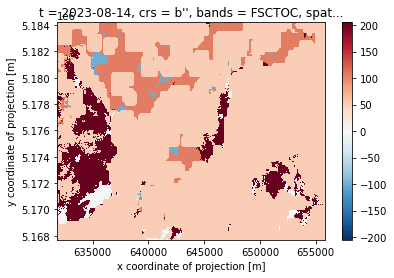

In [42]:
diff_xr = diff.execute().compute()
diff_xr[2,0].plot.imshow()

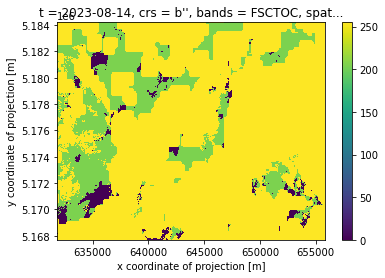

In [23]:
cube_maksed_xr = cube_masked.execute()
cube_maksed_xr[2,0].plot.imshow()

In [ ]:
def partial_SCA(array, valid_scf_vect, mask, cloud_mask, cloud_thres):
    """
    This function calculates the SCF for the cloud masked area as well
    as a variable called "difference" which rapresents the % of the 
    pixels whose classification does not agree
    """
    # number of valid pixels
    pixels_to_check = array[np.logical_and(~mask,~cloud_mask)]
    valid_pixels = np.ma.array(pixels_to_check,mask =pixels_to_check>100)
    N_valid_pixels = np.sum(pixels_to_check<=100)
    N_total_pixels = np.sum(np.logical_and(~mask,~cloud_mask))
    
    
    #cloud percentage w.r.t. to the unmasked area
    clouds= (N_total_pixels-N_valid_pixels)/(N_total_pixels)
    
    #cloud percentage w.r.t. to the unmasked area
    clouds= (N_total_pixels-N_valid_pixels)/(N_total_pixels)
    
    # get SCF of the partial area
    if clouds >= cloud_thres:
        sca = np.nan
        difference = np.nan
    else:
        sca = np.sum(valid_pixels)/N_valid_pixels
        difference = np.sum(abs(valid_pixels - valid_scf_vect))/N_valid_pixels
        
    return sca, difference